In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.model_selection import RepeatedStratifiedKFold

In [2]:
collman15v2 = pd.read_csv('data/collman15v2.csv')
collman14v2 = pd.read_csv('data/collman14v2.csv')

In [3]:
collman14v2 = collman14v2[collman14v2.total != 0]

In [4]:
columns = ['GABA', 'GAD', 'gephyrin', 'NR1', 'PSD', 'Synapsin', 'VGluT1', 'location']

In [5]:
#Create new dataframes using columns above
collman15v2 = collman15v2[columns]
collman14v2 = collman14v2[columns]

In [6]:
collman15v2.head()

,GABA,GAD,gephyrin,NR1,PSD,Synapsin,VGluT1,location
0,0.062382,1.986366,0.385097,0.190005,1.732728,1.001573,0.620783,on_synapse
1,0.077235,1.237165,0.359511,0.330757,1.999066,0.934644,0.289654,on_synapse
2,0.005923,0.371813,0.120297,0.042547,0.033503,0.296893,0.207308,on_synapse
3,0.147710,1.061725,0.306219,0.203209,0.858445,0.687535,0.453936,on_synapse
4,0.096643,0.999047,0.463625,0.307832,0.463181,0.976970,0.307580,on_synapse


In [7]:
collman14v2.head()

,GABA,GAD,gephyrin,NR1,PSD,Synapsin,VGluT1,location
0,0.014463,0.041894,0.157161,0.077249,0.455805,0.060186,0.110704,on_synapse
1,0.029084,0.058346,0.070150,0.064481,0.625653,0.041553,0.091067,on_synapse
3,0.044822,0.041860,0.875676,0.061351,0.035623,0.029494,0.063645,on_synapse
4,0.836592,0.848743,0.436456,0.149300,0.028304,0.262342,0.086698,on_synapse
5,0.019666,0.040624,0.051759,0.074537,0.252298,0.144212,0.036364,on_synapse


In [8]:
pairs = list(itertools.combinations(range(7), 2))

In [9]:
#Matrix for keeping accuracy scores with shape (7, 7)
lda_in_sample_score_matrix = np.ones((7, 7))
lda_out_sample_score_matrix = np.ones((7, 7))

qda_in_sample_score_matrix = np.ones((7, 7))
qda_out_sample_score_matrix = np.ones((7, 7))

# Generate a mask for the upper triangle - for ploting later
mask = np.zeros_like(qda_out_sample_score_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask, k=1)] = True

### Run pairwise channel LDA and QDA using collman15v2 as training data and collman14v2 as test data

In [10]:
#Compute scores for LDA and QDA using collman15v2 as training data and collman14v2 as test data
for i, j in pairs:
    lda_in_sample_scores = []
    lda_out_sample_scores = []
    qda_in_sample_scores = []
    qda_out_sample_scores = []
    
    lda = LinearDiscriminantAnalysis()
    qda = QuadraticDiscriminantAnalysis()
    
    X = collman15v2.iloc[:, i:j+1].values #Data
    y = collman15v2.iloc[:, -1].values #Labels
    
    X2 = collman14v2.iloc[:, i:j+1].values
    y2 = collman14v2.iloc[:, -1].values
    
    skf = RepeatedStratifiedKFold(n_splits=3, random_state=np.random.RandomState()) # 66% train, 33% test
    for train, test in skf.split(X, y):
        lda.fit(X[train], y[train])
        qda.fit(X[train], y[train])
        
        lda_in_sample_scores.append(lda.score(X[test], y[test]))
        lda_out_sample_scores.append(lda.score(X2, y2))
        qda_in_sample_scores.append(qda.score(X[test], y[test]))
        qda_out_sample_scores.append(qda.score(X2, y2))
        
    skf = RepeatedStratifiedKFold(n_splits=3, random_state=np.random.RandomState()) # 33% train, 66% test
    for test, train in skf.split(X, y):
        lda.fit(X[train], y[train])
        qda.fit(X[train], y[train])
        
        lda_in_sample_scores.append(lda.score(X[test], y[test]))
        lda_out_sample_scores.append(lda.score(X2, y2))
        qda_in_sample_scores.append(qda.score(X[test], y[test]))
        qda_out_sample_scores.append(qda.score(X2, y2))
    
    skf = RepeatedStratifiedKFold(n_splits=2, random_state=np.random.RandomState()) # 50% train, 50% test
    for train, test in skf.split(X, y):
        lda.fit(X[train], y[train])
        qda.fit(X[train], y[train])
        
        lda_in_sample_scores.append(lda.score(X[test], y[test]))
        lda_out_sample_scores.append(lda.score(X2, y2))
        qda_in_sample_scores.append(qda.score(X[test], y[test]))
        qda_out_sample_scores.append(qda.score(X2, y2))
    
    lda_in_sample_score_matrix[((i, j), (j, i))] = np.mean(lda_in_sample_scores)
    lda_out_sample_score_matrix[((i, j), (j, i))] = np.mean(lda_out_sample_scores)
    
    qda_in_sample_score_matrix[((i, j), (j, i))] = np.mean(qda_in_sample_scores)
    qda_out_sample_score_matrix[((i, j), (j, i))] = np.mean(qda_out_sample_scores)

### Run single channel LDA and QDA using collman15v2 as training data and collman14v2 as test data

In [11]:
for i, channel in enumerate(columns[:-1]):
    lda_in_sample_scores = []
    lda_out_sample_scores = []
    qda_in_sample_scores = []
    qda_out_sample_scores = []
    
    lda = LinearDiscriminantAnalysis()
    qda = QuadraticDiscriminantAnalysis()
    
    X = collman15v2.iloc[:, i].values.reshape(-1, 1) #Data
    y = collman15v2.iloc[:, -1].values #Labels
    
    X2 = collman14v2.iloc[:, i].values.reshape(-1, 1)
    y2 = collman14v2.iloc[:, -1].values
    
    skf = RepeatedStratifiedKFold(n_splits=3, random_state=np.random.RandomState()) # 66% train, 33% test
    for train, test in skf.split(X, y):
        lda.fit(X[train], y[train])
        qda.fit(X[train], y[train])
        
        lda_in_sample_scores.append(lda.score(X[test], y[test]))
        lda_out_sample_scores.append(lda.score(X2, y2))
        qda_in_sample_scores.append(qda.score(X[test], y[test]))
        qda_out_sample_scores.append(qda.score(X2, y2))
        
    skf = RepeatedStratifiedKFold(n_splits=3, random_state=np.random.RandomState()) # 33% train, 66% test
    for test, train in skf.split(X, y):
        lda.fit(X[train], y[train])
        qda.fit(X[train], y[train])
        
        lda_in_sample_scores.append(lda.score(X[test], y[test]))
        lda_out_sample_scores.append(lda.score(X2, y2))
        qda_in_sample_scores.append(qda.score(X[test], y[test]))
        qda_out_sample_scores.append(qda.score(X2, y2))
    
    skf = RepeatedStratifiedKFold(n_splits=2, random_state=np.random.RandomState()) # 50% train, 50% test
    for train, test in skf.split(X, y):
        lda.fit(X[train], y[train])
        qda.fit(X[train], y[train])
        
        lda_in_sample_scores.append(lda.score(X[test], y[test]))
        lda_out_sample_scores.append(lda.score(X2, y2))
        qda_in_sample_scores.append(qda.score(X[test], y[test]))
        qda_out_sample_scores.append(qda.score(X2, y2))
    
    lda_in_sample_score_matrix[((i, i), (i, i))] = np.mean(lda_in_sample_scores)
    lda_out_sample_score_matrix[((i, i), (i, i))] = np.mean(lda_out_sample_scores)
    
    qda_in_sample_score_matrix[((i, i), (i, i))] = np.mean(qda_in_sample_scores)
    qda_out_sample_score_matrix[((i, i), (i, i))] = np.mean(qda_out_sample_scores)

In [12]:
pd.DataFrame(lda_in_sample_score_matrix, index=columns[:-1], columns=columns[:-1])

,GABA,GAD,gephyrin,NR1,PSD,Synapsin,VGluT1
GABA,0.946756,0.996052,0.997841,0.997880,0.997881,0.997844,0.997713
GAD,0.996052,0.995763,0.997880,0.997878,0.997883,0.997591,0.997763
gephyrin,0.997841,0.997880,0.997884,0.997884,0.997884,0.997762,0.997787
NR1,0.997880,0.997878,0.997884,0.994017,0.995512,0.997761,0.997805
PSD,0.997881,0.997883,0.997884,0.995512,0.875533,0.993649,0.993644
Synapsin,0.997844,0.997591,0.997762,0.997761,0.993649,0.993647,0.993569
VGluT1,0.997713,0.997763,0.997787,0.997805,0.993644,0.993569,0.991238


In [13]:
pd.DataFrame(qda_in_sample_score_matrix, index=columns[:-1], columns=columns[:-1])

,GABA,GAD,gephyrin,NR1,PSD,Synapsin,VGluT1
GABA,0.979062,0.998449,0.994763,0.994640,0.995524,0.996039,0.995433
GAD,0.998449,0.999034,0.995813,0.996084,0.996089,0.996346,0.996810
gephyrin,0.994763,0.995813,0.995763,0.996318,0.995419,0.996205,0.996573
NR1,0.994640,0.996084,0.996318,0.993176,0.994040,0.997735,0.998796
PSD,0.995524,0.996089,0.995419,0.994040,0.874925,0.997802,0.999589
Synapsin,0.996039,0.996346,0.996205,0.997735,0.997802,0.997537,0.997537
VGluT1,0.995433,0.996810,0.996573,0.998796,0.999589,0.997537,0.994291


In [14]:
qda_out_sample_score_df = pd.DataFrame(qda_out_sample_score_matrix, index=columns[:-1], columns=columns[:-1])

lda_out_sample_score_df = pd.DataFrame(lda_out_sample_score_matrix, index=columns[:-1], columns=columns[:-1])

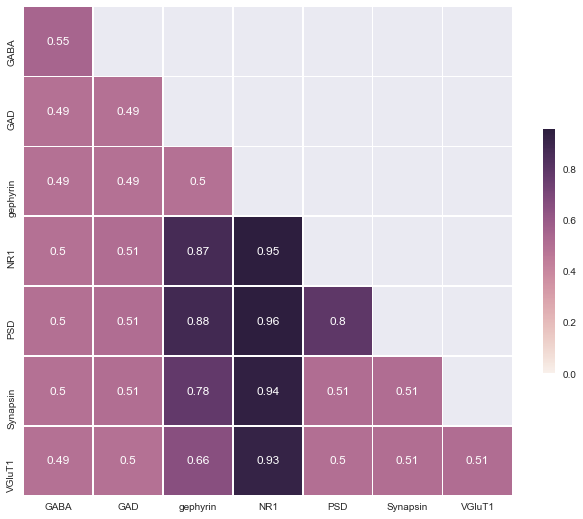

In [15]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(lda_out_sample_score_df, mask=mask, vmin=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

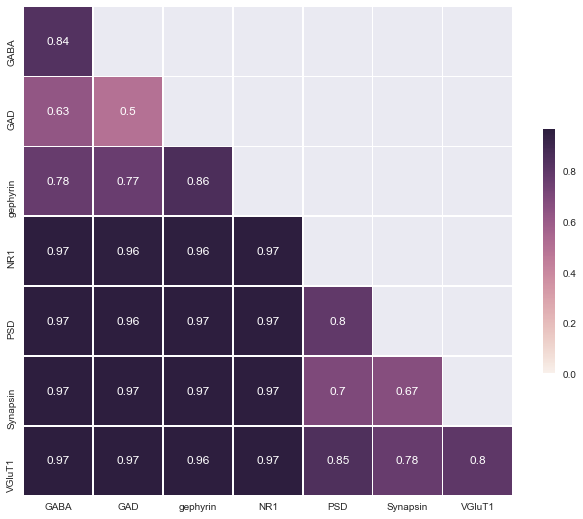

In [16]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(qda_out_sample_score_df, mask=mask, vmin=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

### Run pairwise channel LDA and QDA using collman15v2 as training data and collman14v2 as test data

In [17]:
#Compute scores for LDA and QDA using collman14v2 as training data and collman15v2 as test data
for i, j in pairs:
    lda_in_sample_scores = []
    lda_out_sample_scores = []
    qda_in_sample_scores = []
    qda_out_sample_scores = []
    
    lda = LinearDiscriminantAnalysis()
    qda = QuadraticDiscriminantAnalysis()
    
    X = collman14v2.iloc[:, i:j+1].values #Data
    y = collman14v2.iloc[:, -1].values #Labels
    
    X2 = collman15v2.iloc[:, i:j+1].values
    y2 = collman15v2.iloc[:, -1].values
    
    skf = RepeatedStratifiedKFold(n_splits=3, random_state=np.random.RandomState()) # 66% train, 33% test
    for train, test in skf.split(X, y):
        lda.fit(X[train], y[train])
        qda.fit(X[train], y[train])
        
        lda_in_sample_scores.append(lda.score(X[test], y[test]))
        lda_out_sample_scores.append(lda.score(X2, y2))
        qda_in_sample_scores.append(qda.score(X[test], y[test]))
        qda_out_sample_scores.append(qda.score(X2, y2))
        
    skf = RepeatedStratifiedKFold(n_splits=3, random_state=np.random.RandomState()) # 33% train, 66% test
    for test, train in skf.split(X, y):
        lda.fit(X[train], y[train])
        qda.fit(X[train], y[train])
        
        lda_in_sample_scores.append(lda.score(X[test], y[test]))
        lda_out_sample_scores.append(lda.score(X2, y2))
        qda_in_sample_scores.append(qda.score(X[test], y[test]))
        qda_out_sample_scores.append(qda.score(X2, y2))
    
    skf = RepeatedStratifiedKFold(n_splits=2, random_state=np.random.RandomState()) # 50% train, 50% test
    for train, test in skf.split(X, y):
        lda.fit(X[train], y[train])
        qda.fit(X[train], y[train])
        
        lda_in_sample_scores.append(lda.score(X[test], y[test]))
        lda_out_sample_scores.append(lda.score(X2, y2))
        qda_in_sample_scores.append(qda.score(X[test], y[test]))
        qda_out_sample_scores.append(qda.score(X2, y2))
    
    lda_in_sample_score_matrix[((i, j), (j, i))] = np.mean(lda_in_sample_scores)
    lda_out_sample_score_matrix[((i, j), (j, i))] = np.mean(lda_out_sample_scores)
    
    qda_in_sample_score_matrix[((i, j), (j, i))] = np.mean(qda_in_sample_scores)
    qda_out_sample_score_matrix[((i, j), (j, i))] = np.mean(qda_out_sample_scores)

### Run single channel LDA and QDA using collman15v2 as training data and collman14v2 as test data

In [18]:
#Compute scores for LDA and QDA using collman14v2 as training data and collman15v2 as test data
for i, j in pairs:
    lda_in_sample_scores = []
    lda_out_sample_scores = []
    qda_in_sample_scores = []
    qda_out_sample_scores = []
    
    lda = LinearDiscriminantAnalysis()
    qda = QuadraticDiscriminantAnalysis()
    
    X = collman14v2.iloc[:, i].values.reshape(-1, 1) #Data
    y = collman14v2.iloc[:, -1].values #Labels
    
    X2 = collman15v2.iloc[:, i].values.reshape(-1, 1)
    y2 = collman15v2.iloc[:, -1].values
    
    skf = RepeatedStratifiedKFold(n_splits=3, random_state=np.random.RandomState()) # 66% train, 33% test
    for train, test in skf.split(X, y):
        lda.fit(X[train], y[train])
        qda.fit(X[train], y[train])
        
        lda_in_sample_scores.append(lda.score(X[test], y[test]))
        lda_out_sample_scores.append(lda.score(X2, y2))
        qda_in_sample_scores.append(qda.score(X[test], y[test]))
        qda_out_sample_scores.append(qda.score(X2, y2))
        
    skf = RepeatedStratifiedKFold(n_splits=3, random_state=np.random.RandomState()) # 33% train, 66% test
    for test, train in skf.split(X, y):
        lda.fit(X[train], y[train])
        qda.fit(X[train], y[train])
        
        lda_in_sample_scores.append(lda.score(X[test], y[test]))
        lda_out_sample_scores.append(lda.score(X2, y2))
        qda_in_sample_scores.append(qda.score(X[test], y[test]))
        qda_out_sample_scores.append(qda.score(X2, y2))
    
    skf = RepeatedStratifiedKFold(n_splits=2, random_state=np.random.RandomState()) # 50% train, 50% test
    for train, test in skf.split(X, y):
        lda.fit(X[train], y[train])
        qda.fit(X[train], y[train])
        
        lda_in_sample_scores.append(lda.score(X[test], y[test]))
        lda_out_sample_scores.append(lda.score(X2, y2))
        qda_in_sample_scores.append(qda.score(X[test], y[test]))
        qda_out_sample_scores.append(qda.score(X2, y2))
    
    lda_in_sample_score_matrix[(i, i)] = np.mean(lda_in_sample_scores)
    lda_out_sample_score_matrix[(i, i)] = np.mean(lda_out_sample_scores)
    
    qda_in_sample_score_matrix[(i, i)] = np.mean(qda_in_sample_scores)
    qda_out_sample_score_matrix[(i, i)] = np.mean(qda_out_sample_scores)

In [19]:
pd.DataFrame(lda_in_sample_score_matrix, index=columns[:-1], columns=columns[:-1])

,GABA,GAD,gephyrin,NR1,PSD,Synapsin,VGluT1
GABA,0.906636,0.950081,0.944024,0.949013,0.949760,0.950654,0.951052
GAD,0.950081,0.948846,0.942351,0.948578,0.948855,0.950767,0.950548
gephyrin,0.944024,0.942351,0.930575,0.944677,0.946593,0.947958,0.947607
NR1,0.949013,0.948578,0.944677,0.948113,0.948259,0.948895,0.948497
PSD,0.949760,0.948855,0.946593,0.948259,0.878690,0.910290,0.930253
Synapsin,0.950654,0.950767,0.947958,0.948895,0.910290,0.899540,0.930408
VGluT1,0.951052,0.950548,0.947607,0.948497,0.930253,0.930408,0.991238


In [20]:
pd.DataFrame(qda_in_sample_score_matrix, index=columns[:-1], columns=columns[:-1])

,GABA,GAD,gephyrin,NR1,PSD,Synapsin,VGluT1
GABA,0.974707,0.977391,0.975190,0.973421,0.972281,0.972383,0.972723
GAD,0.977391,0.979253,0.975846,0.973555,0.972690,0.971883,0.972456
gephyrin,0.975190,0.975846,0.955806,0.969472,0.969952,0.968135,0.970022
NR1,0.973421,0.973555,0.969472,0.968549,0.963085,0.965880,0.971282
PSD,0.972281,0.972690,0.969952,0.963085,0.877587,0.940888,0.967594
Synapsin,0.972383,0.971883,0.968135,0.965880,0.940888,0.953086,0.965293
VGluT1,0.972723,0.972456,0.970022,0.971282,0.967594,0.965293,0.994291


In [21]:
qda_out_sample_score_df = pd.DataFrame(qda_out_sample_score_matrix, index=columns[:-1], columns=columns[:-1])

lda_out_sample_score_df = pd.DataFrame(lda_out_sample_score_matrix, index=columns[:-1], columns=columns[:-1])

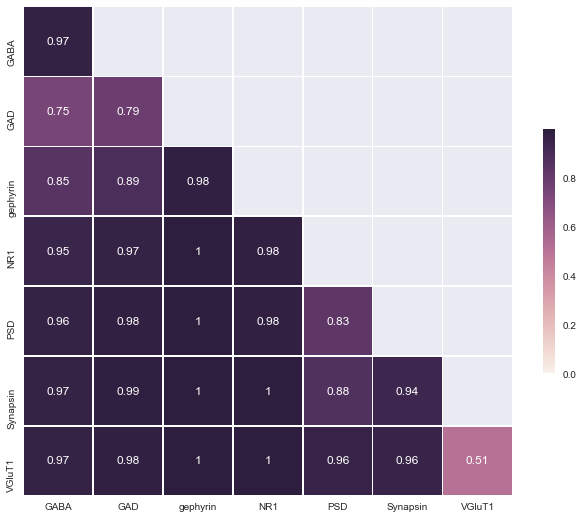

In [22]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(lda_out_sample_score_df, mask=mask, vmin=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

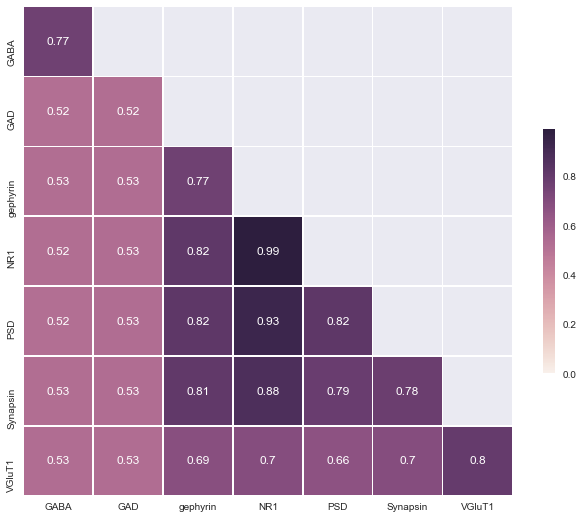

In [23]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(qda_out_sample_score_df, mask=mask, vmin=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()